In [ ]:
%matplotlib inline

# Package and dataset loading

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
]) # Normalize to [-1, 1]


trainvalset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

classes = trainvalset.classes
num_classes = len(classes)

# print(classes)

trainset, valset = torch.utils.data.random_split(trainvalset, [0.9, 0.1])

trainloader = torch.utils.data.DataLoader(trainset, batch_size=64,
                                          shuffle=True)

100%|██████████| 170M/170M [00:03<00:00, 43.6MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


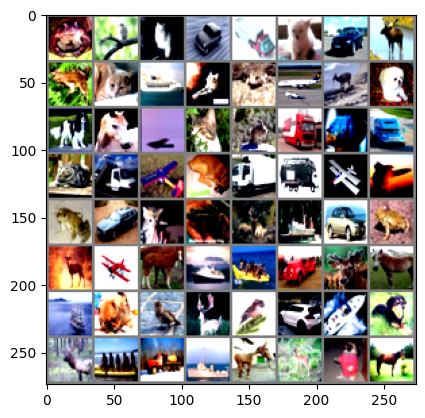

 frog  bird   cat automobile


In [ ]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

# CNN Model Implementation (ResNet)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import os

In [ ]:
# ResNet model

class BasicBlock(nn.Module):
    expansion = 1  # For ResNet18, expansion factor is 1

    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()
        # First convolution layer
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        # Second convolution layer
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        # Skip connection if input and output channels don't match
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet18(nn.Module):
    def __init__(self):
        super(ResNet18, self).__init__()
        # Initial convolution layer
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)

        # Residual layers
        self.layer1 = self._make_layer(64, 64, stride=1)
        self.layer2 = self._make_layer(64, 128, stride=2)
        self.layer3 = self._make_layer(128, 256, stride=2)
        self.layer4 = self._make_layer(256, 512, stride=2)

        # Fully connected layer
        self.fc = nn.Linear(512, 10) # 10 for CIFAR-10

    def _make_layer(self, in_channels, out_channels, stride, num_blocks=2):
        layers = []
        layers.append(BasicBlock(in_channels, out_channels, stride))
        for _ in range(1, num_blocks):
            layers.append(BasicBlock(out_channels, out_channels, stride=1))
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)  # Assuming CIFAR-10, which has 32x32 input
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

# Create an instance of the model
resnet = ResNet18()
print(resnet)


ResNet18(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affin

In [ ]:
model = resnet.to(device)
model

ResNet18(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affin

# Train the model + hyperparameter tuning

Given the high computational load to train, we will limit the hyperparameters to tune with only two combinations of `lr`, `weight_decay`, and data augmentations. We also apply early stopping.

In [ ]:
# Prepare hyperparameters settings

batch_size = 128

# trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
valloader = DataLoader(valset, batch_size=batch_size, shuffle=False)

criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(model.parameters(), lr = 0.0005, weight_decay=1e-4)

In [ ]:
# Apply extra augmentations

class AugmentedDataset(Dataset):
    def __init__(self, base_dataset, extra_transforms=None):
        self.base_dataset = base_dataset
        self.extra_transforms = extra_transforms

    def __getitem__(self, idx):
        img, label = self.base_dataset[idx]

        # Apply the additional transformations if specified
        if self.extra_transforms:
            img = self.extra_transforms(img)

        return img, label

    def __len__(self):
        return len(self.base_dataset)

# Data augmentation transfomations
transform_1 = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip
])

transform_2 = transforms.Compose([
    transforms.RandomRotation(20),
    transforms.RandomHorizontalFlip
])

In [ ]:
# Defining hyperparameters to try

lr = [0.0001, 0.00001] # Lower than the initial test value
weight_decay = [1e-4, 1e-5]
transforms_list = [transform_1, transform_2]

In [ ]:
# Training loop function
# Modified to save the models named after hyperparameters
def train_model(
    model,
    trainloader,
    valloader,
    criterion,
    optimizer,
    num_epochs,
    device,
    lr_i,
    wd_i,
    transform_i,
    patience = 5):

    model.to(device)

    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    best_val_loss = float('inf')

    for epoch in range(num_epochs):

        # Training phase
        model.train()
        running_train_loss = 0.0
        correct_train = 0
        total_train = 0

        for inputs, labels in trainloader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)


            loss.backward()
            optimizer.step()

            running_train_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct_train += (predicted == labels).sum().item()
            total_train += labels.size(0)

        avg_train_loss = running_train_loss / len(trainloader)
        train_accuracy = correct_train / total_train * 100
        train_losses.append(avg_train_loss)
        train_accuracies.append(train_accuracy)

        # Validation phase
        model.eval()
        running_val_loss = 0.0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for inputs, labels in valloader:
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                running_val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                correct_val += (predicted == labels).sum().item()
                total_val += labels.size(0)

        avg_val_loss = running_val_loss / len(valloader)
        val_accuracy = correct_val / total_val * 100
        val_losses.append(avg_val_loss)
        val_accuracies.append(val_accuracy)

        # Print metrics for the epoch
        print(f'Epoch {epoch+1}/{num_epochs}, '
              f'Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, '
              f'Train Acc: {train_accuracy:.2f}%, Val Acc: {val_accuracy:.2f}%')

        # Early stopping logic
        os.makedirs(f'./trans_{transform_i}/wd_{wd_i}/', exist_ok=True)
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            epochs_no_improve = 0  # Reset counter if validation loss improves
            torch.save(model.state_dict(), f'./trans_{transform_i}/wd_{wd_i}/best_model_lr{lr_i}.pth')
        else:
            epochs_no_improve += 1

        # Check if early stopping condition is met
        if epochs_no_improve == patience:
            print(f"Early stopping triggered after {epoch+1} epochs.")
            break

    return model, train_losses, val_losses, train_accuracies, val_accuracies


In [ ]:
# Bigger number of epochs, since we have early stopping anyway
num_epochs = 50

trained_models = []
train_losseses = []
val_losseses = []
train_accuracieses = []
val_accuracieses = []

# Nested loop for hyperparameter tuning
for i, lr_i in enumerate(lr):  # Loop over learning rates
    for j, transform_i in enumerate(transforms_list):  # Loop over transformations
        for k, wd_i in enumerate(weight_decay):  # Loop over weight decays

            # Now you have access to each combination of hyperparameters: lr_i, transform_i, wd_i
            print(f"Training with: LR={lr_i}, Transform={j+1}, WD={wd_i}")

            # Your training logic here
            # Example: model, optimizer setup, training, saving the model, etc.
            model = ResNet18()
            optimizer = torch.optim.Adam(model.parameters(), lr=lr_i, weight_decay=wd_i)
            augmented_trainset = AugmentedDataset(trainset, extra_transforms=transform_i)
            trainloader = DataLoader(augmented_trainset, batch_size=batch_size, shuffle=True)

            # Train the model (you'll replace this with your train_model call)
            trained_model, train_losses, val_losses, train_accuracies, val_accuracies = train_model(
                model, trainloader, valloader, criterion, optimizer, num_epochs, device, lr_i, wd_i, j
            )

            trained_models.append(trained_model)
            train_losseses.append(train_losses)
            val_losseses.append(val_losses)
            train_accuracieses.append(train_accuracies)
            val_accuracieses.append(val_accuracies)


Training with: LR=0.0001, Transform=1, WD=0.0001
Epoch 1/50, Train Loss: 1.4005, Val Loss: 1.1473, Train Acc: 48.70%, Val Acc: 58.22%
Epoch 2/50, Train Loss: 0.9735, Val Loss: 1.0292, Train Acc: 65.34%, Val Acc: 64.22%
Epoch 3/50, Train Loss: 0.7721, Val Loss: 0.8145, Train Acc: 72.84%, Val Acc: 72.26%
Epoch 4/50, Train Loss: 0.6525, Val Loss: 0.7442, Train Acc: 76.81%, Val Acc: 74.30%
Epoch 5/50, Train Loss: 0.5613, Val Loss: 0.6387, Train Acc: 80.48%, Val Acc: 78.42%
Epoch 6/50, Train Loss: 0.4943, Val Loss: 0.6426, Train Acc: 82.86%, Val Acc: 78.56%
Epoch 7/50, Train Loss: 0.4414, Val Loss: 0.6017, Train Acc: 84.60%, Val Acc: 80.66%
Epoch 8/50, Train Loss: 0.3945, Val Loss: 0.5327, Train Acc: 86.20%, Val Acc: 82.44%
Epoch 9/50, Train Loss: 0.3536, Val Loss: 0.5212, Train Acc: 87.73%, Val Acc: 82.86%
Epoch 10/50, Train Loss: 0.3230, Val Loss: 0.5340, Train Acc: 88.79%, Val Acc: 82.48%
Epoch 11/50, Train Loss: 0.2855, Val Loss: 0.6051, Train Acc: 90.06%, Val Acc: 81.54%
Epoch 12/50, T

# Analysis

In [ ]:
# Evaluation function
def evaluation(dataloader, model):
    total, correct = 0, 0
    for data in dataloader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, pred = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (pred == labels).sum().item()
    return correct / total * 100

In [ ]:
train_accuracy = evaluation(trainloader, trained_model)
val_accuracy = evaluation(valloader, trained_model)

print(f'Training Accuracy: : {train_accuracy:.2f}%, Validation Accuracy: {val_accuracy:.2f}%')

Training Accuracy: : 95.32%, Validation Accuracy: 95.54%


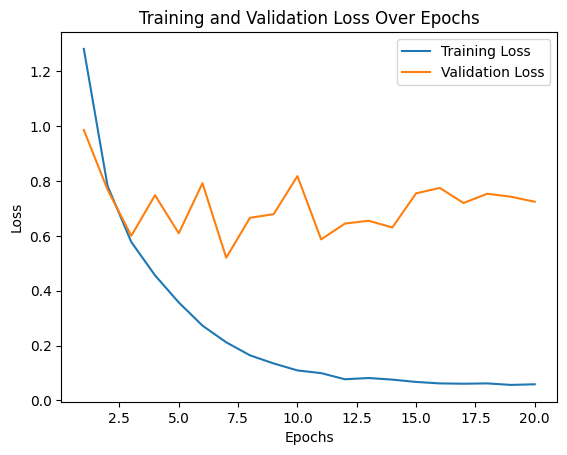

In [ ]:
# Plot loss curves
plt.plot(range(1, num_epochs+1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss Over Epochs')
plt.show()

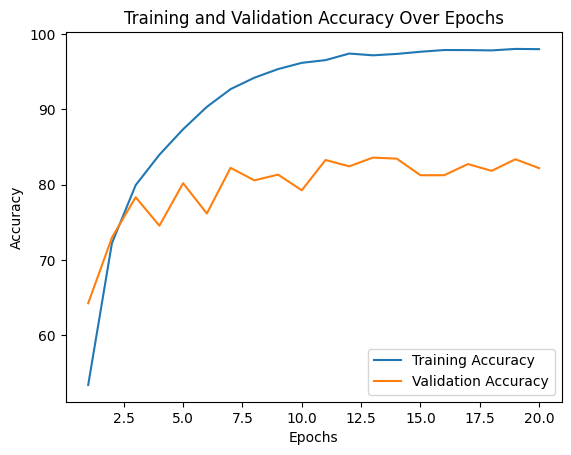

In [ ]:
# Plot accuracy curves
plt.plot(range(1, num_epochs+1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, num_epochs+1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy Over Epochs')
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Calculate predictions on validation set
all_preds = []
all_labels = []
with torch.no_grad():
    for data in valloader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = trained_model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

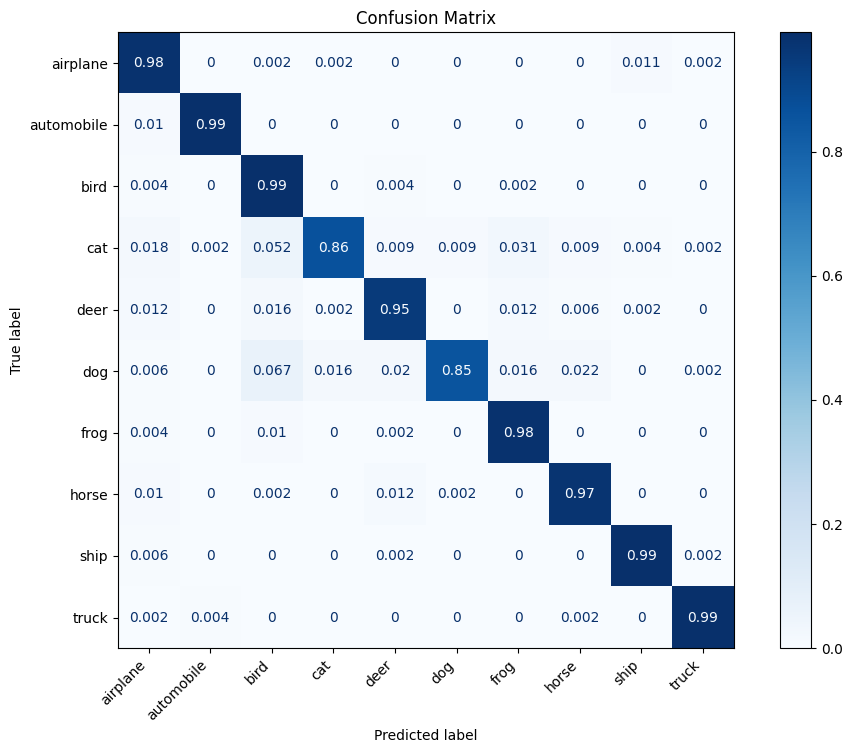

In [ ]:
# Generate confusion matrix
fig, ax = plt.subplots(figsize=(12, 8))

cm = confusion_matrix(all_labels, all_preds)
cm_normalized = np.round(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], 3)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_normalized, display_labels=classes)
disp.plot(cmap=plt.cm.Blues, ax=ax)
plt.title("Confusion Matrix")
plt.xticks(rotation=45, ha='right')
plt.show()

# Test the model

In [ ]:
# Test the model

resnet = ResNet18()
resnet = resnet.to(device)

resnet.load_state_dict(torch.load(f'best_model_{type(resnet).__name__}.pth'))

testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)

C:\Users\irfan\AppData\Local\Temp\ipykernel_20460\112880752.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  resnet.load_state_dict(torch.load(f'best_model_{type(resnet).

In [ ]:
test_accuracy = evaluation(testloader, resnet)

print(f'Test Accuracy: {test_accuracy:.2f}%')

Test Accuracy: 81.76%


In [ ]:
# Calculate predictions on test set
all_preds_test = []
all_labels_test = []
with torch.no_grad():
    for data in testloader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = resnet(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds_test.extend(preds.cpu().numpy())
        all_labels_test.extend(labels.cpu().numpy())

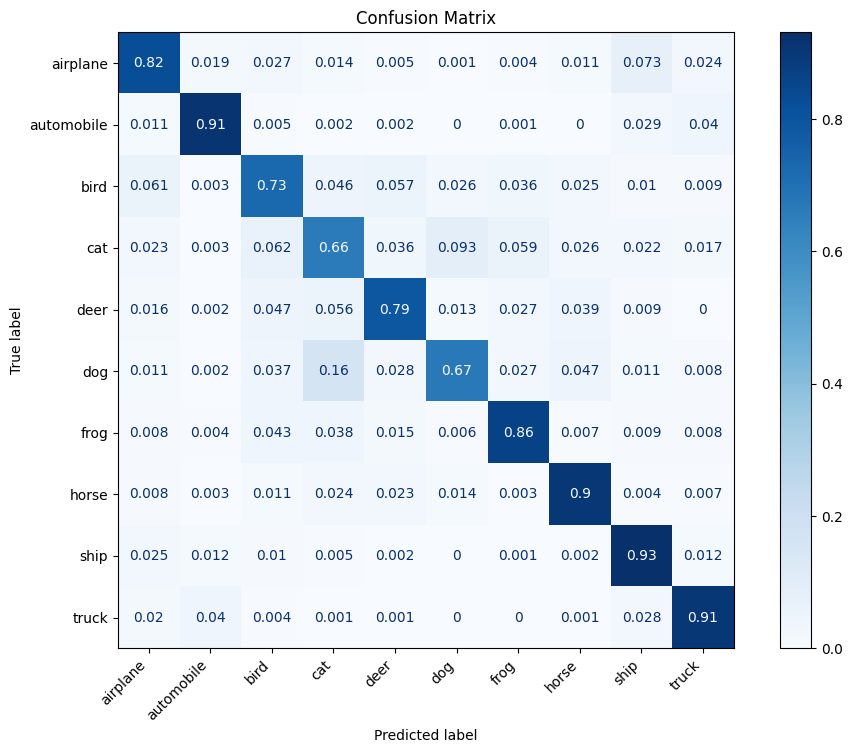

In [ ]:
# Generate confusion matrix
fig, ax = plt.subplots(figsize=(12, 8))

cm = confusion_matrix(all_labels_test, all_preds_test)
cm_normalized = np.round(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], 3)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_normalized, display_labels=classes)
disp.plot(cmap=plt.cm.Blues, ax=ax)
plt.title("Confusion Matrix")
plt.xticks(rotation=45, ha='right')
plt.show()